In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
df=pd.read_csv('/content/combined_social_data_features.csv')

In [ ]:
df

,account_name,caption,comment_count,share_count,like_count,platform,hashtags,mentions,engagement_score,caption_length,word_count,sentiment_score,hashtag_count,mention_count
0,McDonald's,SWIPE TO SEE WHAT PRIZES ARE LEFT!!! IT’S NOT ...,128,31,299,Facebook,NaN,NaN,458,149,29,0.303516,0,0
1,McDonald's,6 episodes\n25 Grimace family members\n1 wacky...,413,59,462,Facebook,NaN,NaN,934,92,16,0.425000,0,0
2,McDonald's,my dms can rest now,612,33,393,Facebook,NaN,NaN,1038,19,5,0.000000,0,0
3,McDonald's,MONOPOLY IS BACK AT McD’S! AVAILABLE ALL DAY! ...,1781,792,2677,Facebook,NaN,NaN,5250,122,23,0.195833,0,0
4,McDonald's,it all started with a McDonald's napkin... a s...,271,71,363,Facebook,NaN,NaN,705,117,19,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1791,gucci,"Attending the premiere for THE TIGER in Milan,...",461,0,35299,Instagram,"['#GucciTheTiger', '#GucciLaFamiglia', '#MFW']","['@alanabc', '@biancahuisman_', '@alexconsani'...",35760,250,36,0.200000,3,18
1792,gucci,Not all answers float to the top.\n\nWatch THE...,234,0,51340,Instagram,"['#GucciTheTiger', '#GucciLaFamiglia', '#MFW']","['@keke', '@halinareijn', '@elliotpage']",51574,111,17,0.500000,3,3
1793,gucci,THE TIGER\n\nA short film by Spike Jonze and H...,1026,0,100009,Instagram,"['#GucciTheTiger', '#GucciLaFamiglia', '#MFW']","['@demimoore', '@halinareijn', '@elliotpage', ...",101035,325,46,0.000000,3,4
1794,gucci,What do you do if you’re in a room with a tige...,354,0,32990,Instagram,"['#GucciTheTiger', '#GucciLaFamiglia', '#MFW']","['@keke', '@demimoore', '@kendalljenner', '@ha...",33344,202,36,0.200000,3,8


In [ ]:
df.isnull().sum()

,0
account_name,0
caption,0
comment_count,0
share_count,0
like_count,0
platform,0
hashtags,1044
mentions,1044
engagement_score,0
caption_length,0


In [ ]:
df[["hashtags","mentions"]]=df[["hashtags","mentions"]].fillna("empty")

In [ ]:
df.isnull().sum()

,0
account_name,0
caption,0
comment_count,0
share_count,0
like_count,0
platform,0
hashtags,0
mentions,0
engagement_score,0
caption_length,0


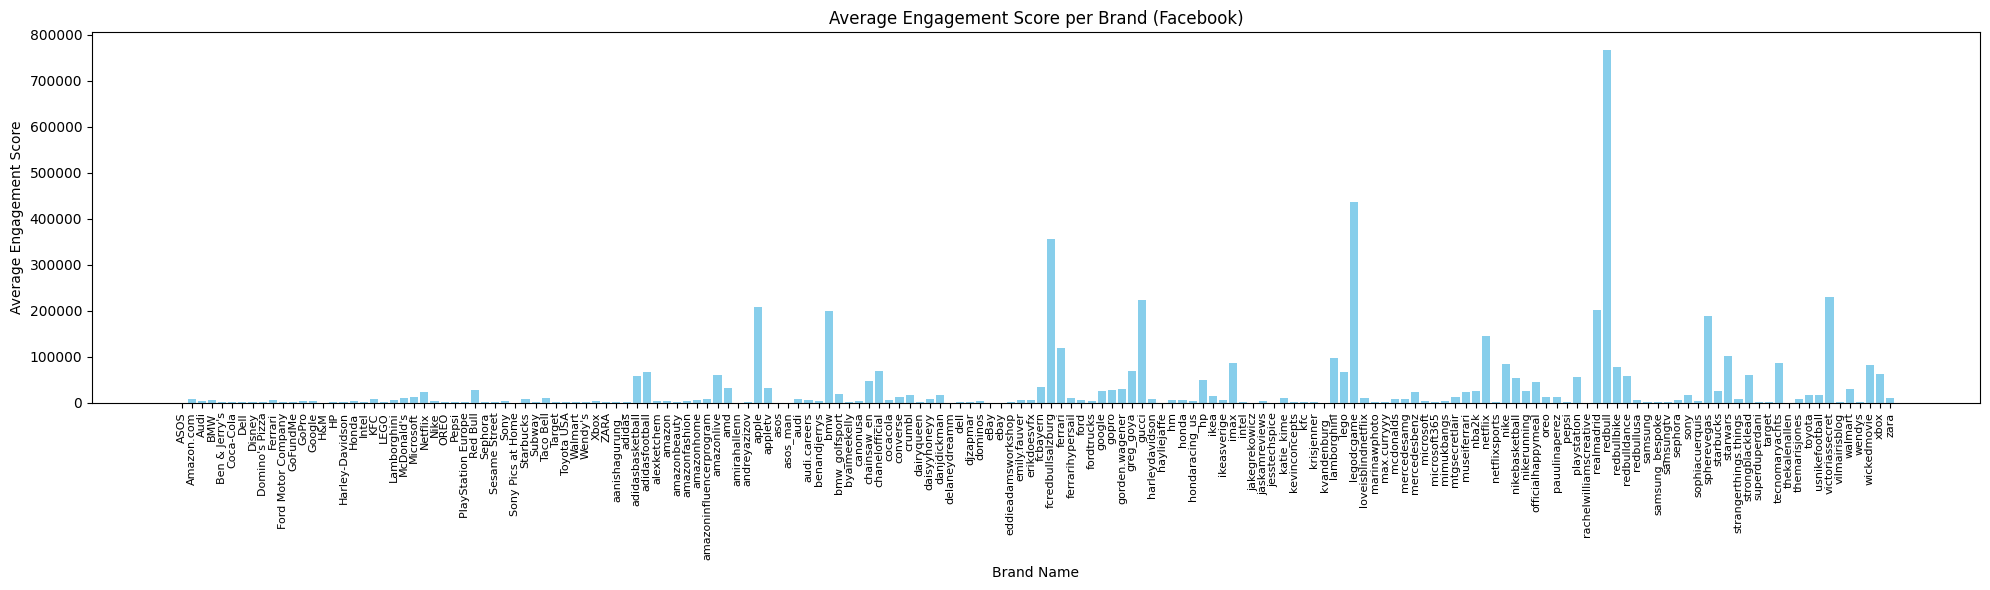

In [ ]:
brand_engagement = df.groupby('account_name')['engagement_score'].mean().reset_index()

# Plot
plt.figure(figsize=(20,6))  # wider figure for more labels
plt.bar(brand_engagement['account_name'], brand_engagement['engagement_score'], color='skyblue')

plt.xlabel('Brand Name')
plt.ylabel('Average Engagement Score')
plt.title('Average Engagement Score per Brand (Facebook)')
plt.xticks(rotation=90, fontsize=8)  # rotate and shrink font
plt.tight_layout()
plt.show()

In [ ]:
lower_power=df['engagement_score'].quantile(0.25)
uper_power=df['engagement_score'].quantile(0.75)
iqr=uper_power-lower_power

In [ ]:
upper_limit=uper_power+1.5*iqr
lower_limit=lower_power-1.5*iqr

In [ ]:
#using iqr triming
df_trimmed = df[
    (df['engagement_score'] > lower_limit) &
    (df['engagement_score'] < upper_limit)
]

/tmp/ipython-input-2173630704.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['engagement_score'])
/tmp/ipython-input-2173630704.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_trimmed['engagement_score'])


<Axes: ylabel='engagement_score'>

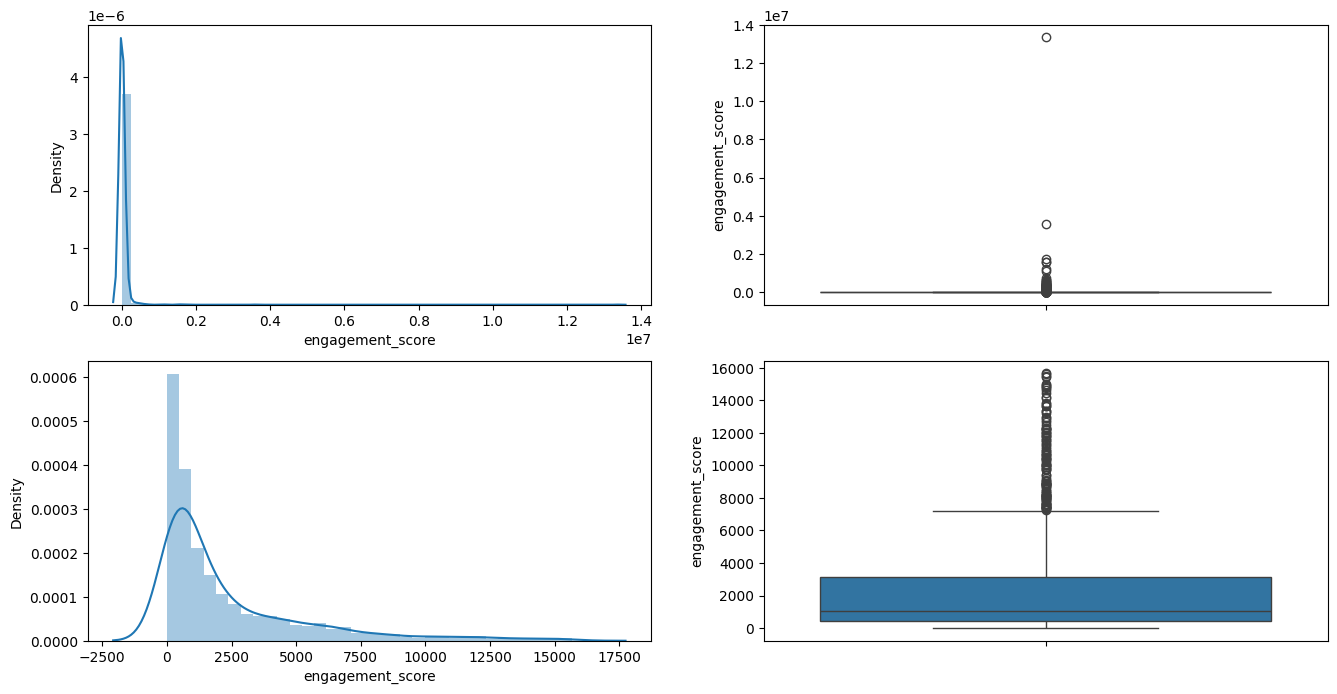

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.distplot(df['engagement_score'])

plt.subplot(2,2,2)
sns.boxplot(df['engagement_score'])

plt.subplot(2,2,3)
sns.distplot(df_trimmed['engagement_score'])

plt.subplot(2,2,4)
sns.boxplot(df_trimmed['engagement_score'])

In [ ]:
#using iqr capping method
new_df_cap=df.copy()
new_df_cap['engagement_score']=np.where(
    new_df_cap['engagement_score']>upper_limit,
    upper_limit,
    np.where(
        new_df_cap['engagement_score']<lower_limit,
        lower_limit,
        new_df_cap['engagement_score']
    )

)


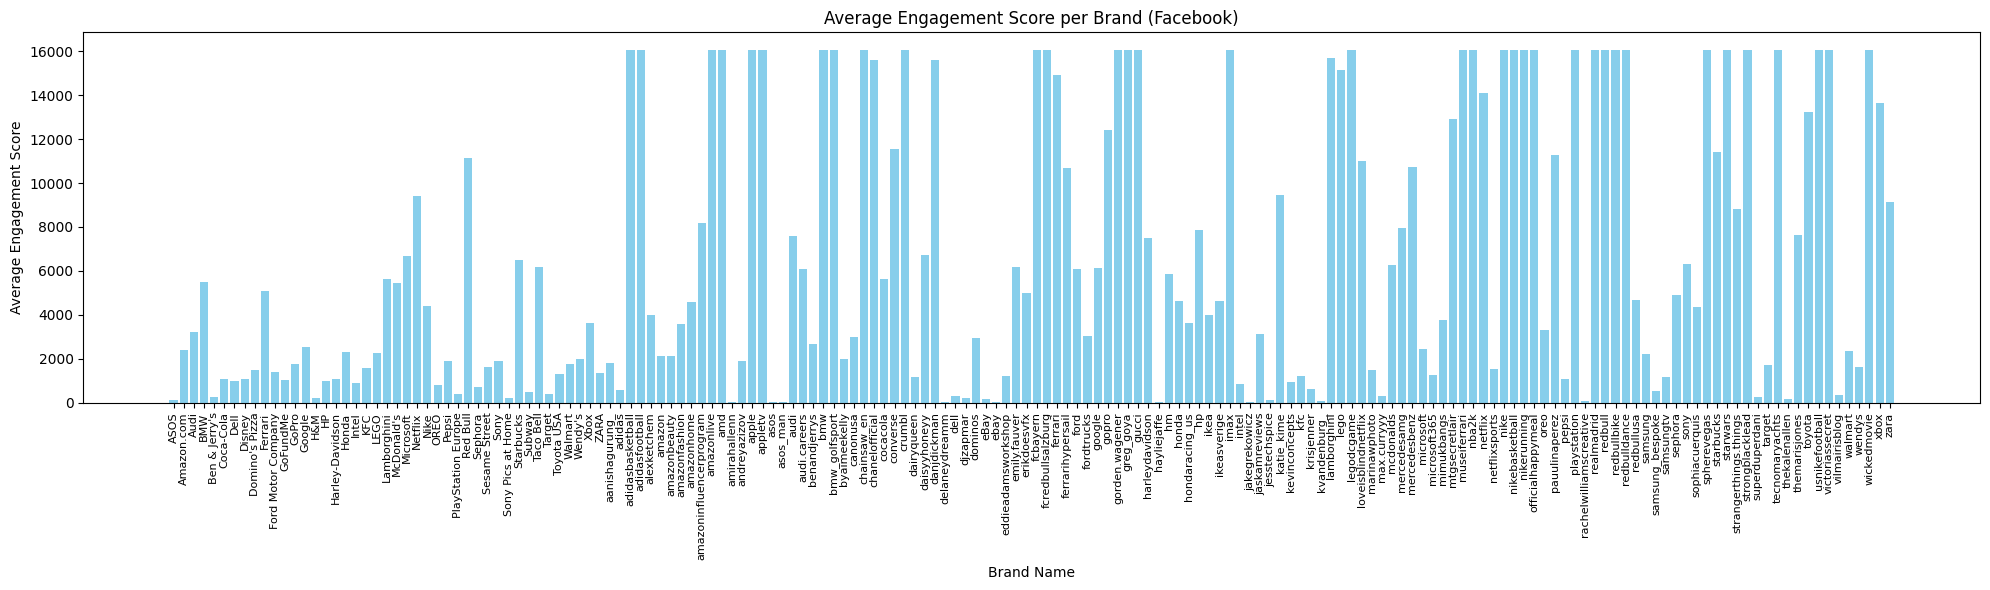

In [ ]:
brand_engagement = new_df_cap.groupby('account_name')['engagement_score'].mean().reset_index()

# Plot
plt.figure(figsize=(20,6))  # wider figure for more labels
plt.bar(brand_engagement['account_name'], brand_engagement['engagement_score'], color='skyblue')

plt.xlabel('Brand Name')
plt.ylabel('Average Engagement Score')
plt.title('Average Engagement Score per Brand (Facebook)')
plt.xticks(rotation=90, fontsize=8)  # rotate and shrink font
plt.tight_layout()
plt.show()

/tmp/ipython-input-196828629.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['engagement_score'])
/tmp/ipython-input-196828629.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df_cap['engagement_score'])


{'whiskers': [<matplotlib.lines.Line2D at 0x783837820ef0>,
 'caps': [<matplotlib.lines.Line2D at 0x7838378214f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x783837820bc0>],
 'medians': [<matplotlib.lines.Line2D at 0x783837821ac0>],
 'fliers': [<matplotlib.lines.Line2D at 0x783837821df0>],
 'means': []}

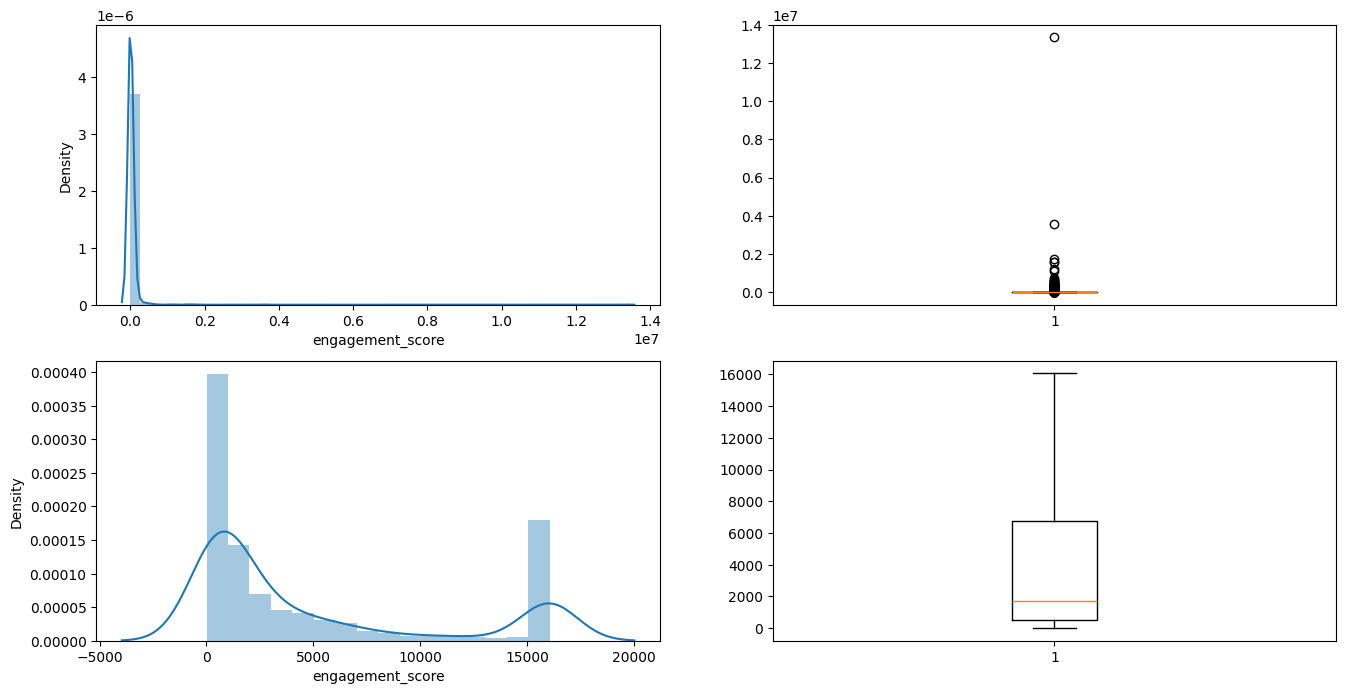

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.distplot(df['engagement_score'])
plt.subplot(2,2,2)
plt.boxplot(df['engagement_score'])
plt.subplot(2,2,3)
sns.distplot(new_df_cap['engagement_score'])
plt.subplot(2,2,4)
plt.boxplot(new_df_cap['engagement_score'])

In [ ]:
new_df_cap.dtypes

,0
account_name,object
caption,object
comment_count,int64
share_count,int64
like_count,int64
platform,object
hashtags,object
mentions,object
engagement_score,float64
caption_length,int64


In [ ]:
X = df.drop('engagement_score', axis=1)
Y = df['engagement_score']

In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
rfR=RandomForestRegressor()

In [ ]:
df.duplicated().sum()


np.int64(1)

In [ ]:
#who are you